In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os
import seaborn as sns
from tqdm.auto import tqdm
import math

/scratch/work/lyub2/.conda_envs/lb-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 新尝试

In [2]:
# Projected coordinate system
MAP_CRS = 'EPSG:3857'
CAL_CRS = 'EPSG:3067'

# EPSG 4326 uses a coordinate system the same as a GLOBE (curved surface). 
# EPSG 3857 uses a coordinate system the same as a MAP (flat surface).
LONLAT_CRS = 'EPSG:4326'

In [3]:
gdf_areas = gpd.read_file(r'/scratch/work/lyub2/HZR/ykr_250_15_kuntaa_grid_v2.geojson').to_crs(CAL_CRS)

In [26]:
gdf_areas.columns

Index(['id', 'geometry'], dtype='object')

### 计算功能定义

In [4]:
def plot_areas(areas):
    plt.figure(figsize=(5, 5), dpi=150)
    ax = plt.subplot(1, 1, 1)
    gdf_areas[gdf_areas['id'].isin(areas)].plot(ax=ax, ec='k')
    #plt.show()

In [5]:
def euclidean_distance(x1, y1, x2, y2):
    if pd.isnull(x2) or pd.isnull(y2):
        return None
    return ((x2 - x1)**2 + (y2 - y1)**2)**0.5

def grids_to_fill_gap(distance, gap_limit=360, grid_size=250):
    if distance <= gap_limit:
        return 0
    effective_gap = distance - gap_limit
    grids_needed = math.ceil(effective_gap / grid_size)
    return grids_needed

def calculate_diff_distances(gdf_tc):
    if 'geometry' not in gdf_tc.columns or not isinstance(gdf_tc['geometry'], gpd.GeoSeries):
        raise ValueError("The geometry column is missing or is not a GeoSeries in gdf_tc.")
    
    gdf_tc['centroid'] = gdf_tc['geometry'].centroid
    gdf_tc['x'] = gdf_tc['centroid'].x
    gdf_tc['y'] = gdf_tc['centroid'].y

    gdf_tc['x_next'] = gdf_tc['x'].shift(-1)
    gdf_tc['y_next'] = gdf_tc['y'].shift(-1)
    gdf_tc['area_id_next'] = gdf_tc['area_id'].shift(-1)

    gdf_tc['diff_dist'] = gdf_tc.apply(
        lambda row: euclidean_distance(row['x'], row['y'], row['x_next'], row['y_next']),
        axis=1
    )
    return gdf_tc

def calculate_areas_next_to_each_other(gdf_tc, gap_limit=360):
    areas_next = gdf_tc[gdf_tc['diff_dist'] <= gap_limit].dropna(subset=['diff_dist'])
    adjacent_pairs = areas_next.apply(
        lambda row: {
            'index': row.name,
            'area_id_current': row['area_id'],
            'area_id_next': row['area_id_next'],
            'distance': row['diff_dist']
        },
        axis=1
    ).tolist()
    return adjacent_pairs

def calculate_areas_with_gaps(gdf_tc, gap_limit=360, grid_size=250):
    gdf_tc_gap = gdf_tc[gdf_tc['diff_dist'] > gap_limit].dropna(subset=['diff_dist'])
    if gdf_tc_gap.empty:
        return []
    else:
        gdf_tc_gap['grids_needed'] = gdf_tc_gap['diff_dist'].apply(
            lambda d: grids_to_fill_gap(d, gap_limit, grid_size)
        )
        gaps = gdf_tc_gap.apply(
            lambda row: {
                'index': row.name,
                'area_id_current': row['area_id'],
                'area_id_next': row['area_id_next'],
                'distance': row['diff_dist'],
                'grids_needed': row['grids_needed']
            },
            axis=1
        ).tolist()
        return gaps

def measure_distance_gap(df_tc):
    GAP_LIMIT = 360
    GRID_SIZE = 250

    gdf_tc = gdf_areas.merge(df_tc, left_on='id', right_on='area_id')
    gdf_tc = gpd.GeoDataFrame(gdf_tc, geometry='geometry') ## 新加的
    gdf_tc = gdf_tc.sort_values('area_order').reset_index(drop=True)

    gdf_tc = calculate_diff_distances(gdf_tc)

    #print("gdf_tc['diff_dist'] ",gdf_tc['diff_dist'])
    dist_total = gdf_tc['diff_dist'].sum() 

    dist_adj = gdf_tc[gdf_tc['diff_dist'] <= GAP_LIMIT]['diff_dist'].sum()
    gap_ratio = ((dist_total - dist_adj) / dist_total) if dist_total else 0
    dist_count = gdf_tc['diff_dist'].count()

    adjacent_pairs = calculate_areas_next_to_each_other(gdf_tc, GAP_LIMIT)
    gaps = calculate_areas_with_gaps(gdf_tc, GAP_LIMIT, GRID_SIZE)

    dist_gap_min = gdf_tc[gdf_tc['diff_dist'] > GAP_LIMIT]['diff_dist'].min()
    dist_gap_max = gdf_tc[gdf_tc['diff_dist'] > GAP_LIMIT]['diff_dist'].max() 
    dist_gap_mean = gdf_tc[gdf_tc['diff_dist'] > GAP_LIMIT]['diff_dist'].mean() 
    dist_gap_count = gdf_tc[gdf_tc['diff_dist'] > GAP_LIMIT]['diff_dist'].count() 

    areas = set([x['area_id_current'] for x in adjacent_pairs] + [x['area_id_next'] for x in adjacent_pairs])
    area_next_to_each_other = len(areas)

    areas_with_gaps = np.sum([x['grids_needed'] for x in gaps])
    
    # print(f"Total distance: {dist_total}") #完整的包含gap和没有gap的距离计算结果
    # print(f"Adjacent distance: {dist_adj}")#相邻的area的总长度
    # #print(f"Total intervals: {dist_count}")
    # print(f"Adjacent/Total distance ratio: {round(dist_adj / dist_total * 100, 2) if dist_total else 0}") #这个leg里 非gap区域的距离占比
    # print(f"Gap min distance: {dist_gap_min}")
    # print(f"Gap max distance: {dist_gap_max}")
    # print(f"Gap mean distance: {dist_gap_mean}")
    # print(f"Gap count: {dist_gap_count}") #这个leg里一共有几段gap
    # print(f"Number of adjacent pairs: {len(adjacent_pairs)}")
    # #print(f"Number of gaps: {len(gaps)}")
    # print(f"Areas next to each other: {area_next_to_each_other}") #这个leg里所有有相邻的areas的数量
    # print(f"Areas with gaps: {areas_with_gaps}") #要填补这个leg里所有gap需要的格子数量
    
    # print("Gaps:")
    # for gap in gaps:
    #     print(gap)
    # print("\n")
    
    # areas = gdf_tc['area_id'].astype(int).values
    # plot_areas(areas)

    #return adjacent_pairs, gaps 
    return adjacent_pairs, gaps, dist_total, dist_adj, gap_ratio, dist_gap_min, dist_gap_max, dist_gap_mean, dist_gap_count, area_next_to_each_other

In [38]:
adjacent_pairs, gaps = measure_distance_gap(sorted_tram.head(27))
adjacent_pairs

[{'index': 0,
  'area_id_current': 70042.0,
  'area_id_next': 70042.0,
  'distance': 0.0},
 {'index': 1,
  'area_id_current': 70042.0,
  'area_id_next': 70042.0,
  'distance': 0.0},
 {'index': 2,
  'area_id_current': 70042.0,
  'area_id_next': 69127.0,
  'distance': 250.00000000093132},
 {'index': 3,
  'area_id_current': 69127.0,
  'area_id_next': 69127.0,
  'distance': 0.0},
 {'index': 4,
  'area_id_current': 69127.0,
  'area_id_next': 69127.0,
  'distance': 0.0},
 {'index': 5,
  'area_id_current': 69127.0,
  'area_id_next': 69128.0,
  'distance': 249.9999999999418},
 {'index': 6,
  'area_id_current': 69128.0,
  'area_id_next': 69128.0,
  'distance': 0.0},
 {'index': 7,
  'area_id_current': 69128.0,
  'area_id_next': 69128.0,
  'distance': 0.0},
 {'index': 8,
  'area_id_current': 69128.0,
  'area_id_next': 68323.0,
  'distance': 249.99999999906868},
 {'index': 9,
  'area_id_current': 68323.0,
  'area_id_next': 68323.0,
  'distance': 0.0},
 {'index': 10,
  'area_id_current': 68323.0,
 

In [87]:
group = sorted_bus.head(1000).groupby("temp_device")
for temp_device, df in group:
    if len(df.leg_order.unique())>1:
        print(temp_device,len(df.leg_order.unique()) )

000OM3CXMpmd 2
0027AfcePA3w 3
0028zaGIy9ki 3
003za0UCaFe4 2
004rm1ePFm5i 2
005kboCECfb0 2
005yJIA58wyD 2


In [90]:
test_df = group.get_group("000OM3CXMpmd").reset_index(drop=True)
test_df

,temp_device,tripchain_id,leg_order,area_id,area_order,mode
0,000OM3CXMpmd,0.0,3.0,64989.0,12.0,BUS
1,000OM3CXMpmd,0.0,3.0,64991.0,13.0,BUS
2,000OM3CXMpmd,0.0,3.0,64299.0,14.0,BUS
3,000OM3CXMpmd,0.0,3.0,63709.0,15.0,BUS
4,000OM3CXMpmd,0.0,3.0,63092.0,16.0,BUS
...,...,...,...,...,...,...
57,000OM3CXMpmd,1.0,1.0,62477.0,29.0,BUS
58,000OM3CXMpmd,1.0,1.0,62476.0,30.0,BUS
59,000OM3CXMpmd,1.0,1.0,63092.0,31.0,BUS
60,000OM3CXMpmd,1.0,1.0,63709.0,32.0,BUS


In [96]:
test_df['td_tc_lo'] = test_df["temp_device"]+"_"+ test_df["tripchain_id"].astype(str)+"_"+test_df["leg_order"].astype(str)
test_df

,temp_device,tripchain_id,leg_order,area_id,area_order,mode,td_tc_lo
0,000OM3CXMpmd,0.0,3.0,64989.0,12.0,BUS,000OM3CXMpmd_0.0_3.0
1,000OM3CXMpmd,0.0,3.0,64991.0,13.0,BUS,000OM3CXMpmd_0.0_3.0
2,000OM3CXMpmd,0.0,3.0,64299.0,14.0,BUS,000OM3CXMpmd_0.0_3.0
3,000OM3CXMpmd,0.0,3.0,63709.0,15.0,BUS,000OM3CXMpmd_0.0_3.0
4,000OM3CXMpmd,0.0,3.0,63092.0,16.0,BUS,000OM3CXMpmd_0.0_3.0
...,...,...,...,...,...,...,...
57,000OM3CXMpmd,1.0,1.0,62477.0,29.0,BUS,000OM3CXMpmd_1.0_1.0
58,000OM3CXMpmd,1.0,1.0,62476.0,30.0,BUS,000OM3CXMpmd_1.0_1.0
59,000OM3CXMpmd,1.0,1.0,63092.0,31.0,BUS,000OM3CXMpmd_1.0_1.0
60,000OM3CXMpmd,1.0,1.0,63709.0,32.0,BUS,000OM3CXMpmd_1.0_1.0


In [85]:
test_df =sorted_bus[sorted_bus.temp_device=="000OM3CXMpmd"].reset_index(inplace=True)
test_df

In [86]:
test_df

In [ ]:
def identify_mode(z):
    if not pd.isna(z['line_type']):
        return z['line_type']
    else:
        return z['activity']

## 获取输入数据

### 试这个

In [ ]:
df_tc_01 = pd.read_csv('/scratch/work/lyub2/Problem_output_September/P4/df_p41.csv', usecols= ['temp_device', 'tripchain_id', 'leg_order', 'activity', 'line_type', 'area_order', 'area_id'])
df_tc = df_tc_01.dropna(subset=['leg_order', 'activity', 'line_type'], how='all').reset_index(drop=True)

/tmp/ipykernel_3286701/3541719597.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tc_01 = pd.read_csv('/scratch/work/lyub2/Problem_output_September/P4/df_p41.csv', usecols= ['temp_device', 'tripchain_id', 'leg_order', 'activity', 'line_type', 'area_order', 'area_id'])


In [ ]:
df = pd.read_csv('/scratch/work/lyub2/Problem_output_September/P4/df_p41.csv', usecols= ['temp_device', 'tripchain_id', 'leg_order', 'activity', 'line_type', 'area_order', 'area_id'])
df_tc_02 = df_tc_02.dropna(subset=['leg_order', 'activity', 'line_type'], how='all').reset_index(drop=True)

In [ ]:
def identify_mode(z):
    if not pd.isna(z['line_type']):
        return z['line_type']
    else:
        return z['activity']
        
df_tc['mode'] = df_tc.apply(identify_mode, axis=1)

In [ ]:
df_walking = df_tc_01[df_tc_01['activity'] == 'WALKING']

In [ ]:
df_walking

,temp_device,tripchain_id,leg_order,area_id,area_order,activity,line_type
111,jelLoknH162b,0.0,1.0,56789.0,2.0,WALKING,NaN
112,jelLoknH162b,0.0,1.0,56788.0,3.0,WALKING,NaN
123,yIKqMeFibPXa,0.0,0.0,58100.0,0.0,WALKING,NaN
124,yIKqMeFibPXa,0.0,0.0,63707.0,1.0,WALKING,NaN
126,GFeSeZhojxwm,0.0,0.0,65824.0,1.0,WALKING,NaN
...,...,...,...,...,...,...,...
32772884,V8h4G6Gc7Ski,0.0,0.0,34017.0,40.0,WALKING,NaN
32773014,uKNIxzkZWsPN,0.0,0.0,52425.0,0.0,WALKING,NaN
32773015,uKNIxzkZWsPN,0.0,0.0,50488.0,1.0,WALKING,NaN
32773309,ecKVb5tmuCTJ,0.0,1.0,48517.0,28.0,WALKING,NaN


In [ ]:
#df_tc_test = df_tc.head(200000)

In [ ]:
folder_path = '/scratch/work/lyub2/Problem_output_September'
file_names = [f'df_p{i}.csv' for i in range(41, 47)]

filtered_dfs = []

for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    print(file_path)

print(file_names)

/scratch/work/lyub2/Problem_output_September/df_p41.csv
/scratch/work/lyub2/Problem_output_September/df_p42.csv
/scratch/work/lyub2/Problem_output_September/df_p43.csv
/scratch/work/lyub2/Problem_output_September/df_p44.csv
/scratch/work/lyub2/Problem_output_September/df_p45.csv
/scratch/work/lyub2/Problem_output_September/df_p46.csv
['df_p41.csv', 'df_p42.csv', 'df_p43.csv', 'df_p44.csv', 'df_p45.csv', 'df_p46.csv']


### 非公共交通的

In [ ]:

folder_path = '/scratch/work/lyub2/Problem_output_September/P4'
file_names = [f'df_p{i}.csv' for i in range(41, 47)]

filtered_dfs = []

for file_name in tqdm(file_names):
    file_path = os.path.join(folder_path, file_name)
    
    df = pd.read_csv(file_path, usecols= ['temp_device', 'tripchain_id', 'leg_order', 'activity', 'line_type', 'area_order', 'area_id'])
    df = df.dropna(subset=['leg_order', 'activity'], how='any').reset_index(drop=True)
        
    df_filtered = df[df['activity'].notnull() & df['line_type'].isnull()]
    filtered_dfs.append(df_filtered)

df_nonPT = pd.concat(filtered_dfs, ignore_index=True)
df_nonPT = df_nonPT.drop(columns=['line_type'])
df_nonPT.rename(columns={'activity': 'mode'}, inplace=True)

print('start saving file~')
df_nonPT.to_csv('/scratch/work/lyub2/Problem_output_September/P4/df_nonPT.csv', index=False)
print('DONE!')

  0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_517226/2379088468.py:9: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, usecols= ['temp_device', 'tripchain_id', 'leg_order', 'activity', 'line_type', 'area_order', 'area_id'])
/tmp/ipykernel_517226/2379088468.py:9: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, usecols= ['temp_device', 'tripchain_id', 'leg_order', 'activity', 'line_type', 'area_order', 'area_id'])


start saving file~
DONE!


In [ ]:
df_nonPT

,temp_device,tripchain_id,leg_order,area_id,area_order,mode
0,jelLoknH162b,0.0,0.0,56792.0,0.0,IN_VEHICLE
1,jelLoknH162b,0.0,0.0,56791.0,1.0,IN_VEHICLE
2,jelLoknH162b,0.0,1.0,56789.0,2.0,WALKING
3,jelLoknH162b,0.0,1.0,56788.0,3.0,WALKING
4,jelLoknH162b,1.0,0.0,64989.0,0.0,IN_VEHICLE
...,...,...,...,...,...,...
78209284,PsVhPwUuuBI4,0.0,0.0,27558.0,16.0,WALKING
78209285,PsVhPwUuuBI4,0.0,1.0,27558.0,16.0,WALKING
78209286,w15wDe1fb2sI,0.0,3.0,70001.0,3.0,WALKING
78209287,FfPUD6vxsNrN,0.0,0.0,54049.0,2.0,WALKING


### 公共交通的

In [ ]:
folder_path = '/scratch/work/lyub2/Problem_output_September/P4'
file_names = [f'df_p{i}.csv' for i in range(41, 47)]

filtered_dfs = []

for file_name in tqdm(file_names):
    file_path = os.path.join(folder_path, file_name)
    
    df = pd.read_csv(file_path, usecols= ['temp_device', 'tripchain_id', 'leg_order', 'line_type', 'area_order', 'area_id'])
    df = df.dropna(subset=['leg_order', 'line_type'], how='any').reset_index(drop=True)
    filtered_dfs.append(df)

df_PT = pd.concat(filtered_dfs, ignore_index=True)
df_PT.rename(columns={'line_type': 'mode'}, inplace=True)

print('start saving file~')
df_PT.to_csv('/scratch/work/lyub2/Problem_output_September/P4/df_PT.csv', index=False)
print('DONE!')

  0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_517226/1244946812.py:9: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, usecols= ['temp_device', 'tripchain_id', 'leg_order', 'line_type', 'area_order', 'area_id'])
/tmp/ipykernel_517226/1244946812.py:9: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, usecols= ['temp_device', 'tripchain_id', 'leg_order', 'line_type', 'area_order', 'area_id'])


start saving file~
DONE!


In [ ]:
df_PT

,temp_device,tripchain_id,leg_order,area_id,area_order,mode
0,mLBH9BYePp6u,0.0,3.0,34709.0,76.0,BUS
1,mLBH9BYePp6u,0.0,3.0,34709.0,76.0,BUS
2,mLBH9BYePp6u,0.0,3.0,30375.0,87.0,BUS
3,mLBH9BYePp6u,0.0,3.0,30375.0,87.0,BUS
4,mLBH9BYePp6u,0.0,3.0,29017.0,92.0,BUS
...,...,...,...,...,...,...
56098619,ciJcewM0mr8V,1.0,0.0,63092.0,4.0,BUS
56098620,r5qosTdRWpF3,2.0,1.0,55661.0,36.0,BUS
56098621,G6IvMSV94Zi6,0.0,1.0,53509.0,11.0,BUS
56098622,UjVdCou5qOMZ,1.0,1.0,67621.0,18.0,BUS


In [ ]:
df_p4.to_csv('/scratch/work/lyub2/Problem_output_September/P4/df_p4.csv', index=False)

## 终于可以跑功能了！

In [6]:
df_PT = pd.read_csv('/scratch/work/lyub2/Problem_output_September/P4/df_PT.csv')

In [6]:
df_nonPT = pd.read_csv('/scratch/work/lyub2/Problem_output_September/P4/df_nonPT.csv')

In [9]:
print(df_PT['mode'].unique())
print(df_nonPT['mode'].unique())

['BUS' 'TRAIN' 'SUBWAY' 'TRAM' 'UBUS' 'FERRY']
['IN_VEHICLE' 'WALKING' 'RUNNING' 'UNKNOWN' 'ON_BICYCLE' 'BEACON']


In [7]:
df_bus = df_PT[df_PT['mode'] == 'BUS']
df_train = df_PT[df_PT['mode'] == 'TRAIN']
df_subway = df_PT[df_PT['mode'] == 'SUBWAY']
df_tram = df_PT[df_PT['mode'] == 'TRAM']
df_ubus = df_PT[df_PT['mode'] == 'UBUS']
df_ferry = df_PT[df_PT['mode'] == 'FERRY']

In [7]:
df_car = df_nonPT[df_nonPT['mode'] == 'IN_VEHICLE']
df_walk = df_nonPT[df_nonPT['mode'] == 'WALKING']
df_run = df_nonPT[df_nonPT['mode'] == 'RUNNING']
df_bike = df_nonPT[df_nonPT['mode'] == 'ON_BICYCLE']
df_unknown = df_nonPT[df_nonPT['mode'] == 'UNKNOWN']
df_beacon = df_nonPT[df_nonPT['mode'] == 'BEACON']

In [8]:
df_bus

,temp_device,tripchain_id,leg_order,area_id,area_order,mode
0,mLBH9BYePp6u,0.0,3.0,34709.0,76.0,BUS
1,mLBH9BYePp6u,0.0,3.0,34709.0,76.0,BUS
2,mLBH9BYePp6u,0.0,3.0,30375.0,87.0,BUS
3,mLBH9BYePp6u,0.0,3.0,30375.0,87.0,BUS
4,mLBH9BYePp6u,0.0,3.0,29017.0,92.0,BUS
...,...,...,...,...,...,...
56098619,ciJcewM0mr8V,1.0,0.0,63092.0,4.0,BUS
56098620,r5qosTdRWpF3,2.0,1.0,55661.0,36.0,BUS
56098621,G6IvMSV94Zi6,0.0,1.0,53509.0,11.0,BUS
56098622,UjVdCou5qOMZ,1.0,1.0,67621.0,18.0,BUS


In [15]:
#大宝贝！终于出来了！

def get_change_indices(df):
    # Identify where the 'id' changes
    df['td_tc_lo'] = df["temp_device"]+"_"+ df["tripchain_id"].astype(str)+"_"+df["leg_order"].astype(str)
    change_indices = df.index[df['td_tc_lo'] != df['td_tc_lo'].shift()].tolist()
    # Exclude the first index since we only want where changes occur after the start
    
    return change_indices

def calculate_legs_onfire(df):

    result =  []

    print('Start sorting')
    sorted_df = df.sort_values(['temp_device', 'tripchain_id', 'leg_order', 'area_order']).reset_index(drop=True)
    print('Sorting done')
    
    change_indices = get_change_indices(sorted_df)
    change_indices.append(len(sorted_df))
    
    

    for i in tqdm(range(len(change_indices)-1)):
        # Extract row values
        
        df_temp = sorted_df.iloc[change_indices[i]:change_indices[i+1]].reset_index(drop=True)
        temp_device,tripchain_id,leg_order = df_temp.td_tc_lo[0].split("_")
 
        mode = df_temp["mode"][0]
        
        # obtain data from measure_distance_gap function.
        adjacent_pairs, gaps, dist_total, dist_adj, gap_ratio, dist_gap_min, dist_gap_max, dist_gap_mean, dist_gap_count, area_next_to_each_other  = measure_distance_gap(df_temp)

        result.append({
            'Mode' : mode,
            'Temp' : temp_device,
            'Tripchain ID' : tripchain_id,
            'Leg Order' : leg_order,
            'Total distance': dist_total,
            'Adjacent distance': dist_adj,
            'Gap ratio': gap_ratio,
            'Gap min distance': dist_gap_min,
            'Gap max distance': dist_gap_max,
            'Gap mean distance': dist_gap_mean,
            'Gap count': dist_gap_count, 
            'Areas next to each other':area_next_to_each_other
            })


    print('Convert to df and saving as csv')
    result = pd.DataFrame(result)
    result.to_csv('/scratch/work/lyub2/Problem_output_September/P4/P4_ferry.csv',index = False)
    return pd.DataFrame(result)


In [15]:
P4_car = calculate_legs_onfire(df_car)

Start sorting


: 

In [10]:
P4_train = calculate_legs_onfire(df_train)

Start sorting
Sorting done


  0%|          | 0/254588 [00:00<?, ?it/s]

Convert to df and saving as csv


In [14]:
P4_ubus = calculate_legs_onfire(df_ubus)

Start sorting
Sorting done


  0%|          | 0/2908 [00:00<?, ?it/s]

Convert to df and saving as csv


In [16]:
P4_ferry = calculate_legs_onfire(df_ferry)

Start sorting
Sorting done


  0%|          | 0/1110 [00:00<?, ?it/s]

Convert to df and saving as csv


In [137]:
tram_test = calculate_legs_onfire(df_tram.head(300))

Start sorting
Sorting done


  0%|          | 0/29 [00:00<?, ?it/s]

Convert to DF


In [10]:
#大宝贝！终于出来了！

def get_change_indices(df):
    # Identify where the 'id' changes
    df['td_tc_lo'] = df["temp_device"]+"_"+ df["tripchain_id"].astype(str)+"_"+df["leg_order"].astype(str)
    change_indices = df.index[df['td_tc_lo'] != df['td_tc_lo'].shift()].tolist()
    # Exclude the first index since we only want where changes occur after the start
    
    return change_indices

def calculate_legs_onfire(df):

    result =  []

    print('Start sorting')
    sorted_df = df.sort_values(['temp_device', 'tripchain_id', 'leg_order', 'area_order']).reset_index(drop=True)
    print('Sorting done')
    
    change_indices = get_change_indices(sorted_df)
    change_indices.append(len(sorted_df))
    
    

    for i in tqdm(range(len(change_indices)-1)):
        # Extract row values
        
        df_temp = sorted_df.iloc[change_indices[i]:change_indices[i+1]].reset_index(drop=True)
        temp_device,tripchain_id,leg_order = df_temp.td_tc_lo[0].split("_")
 
        mode = df_temp["mode"][0]
        
        # obtain data from measure_distance_gap function.
        adjacent_pairs, gaps, dist_total, dist_adj, gap_ratio, dist_gap_min, dist_gap_max, dist_gap_mean, dist_gap_count, area_next_to_each_other  = measure_distance_gap(df_temp)

        result.append({
            'Mode' : mode,
            'Temp' : temp_device,
            'Tripchain ID' : tripchain_id,
            'Leg Order' : leg_order,
            'Total distance': dist_total,
            'Adjacent distance': dist_adj,
            'Gap ratio': gap_ratio,
            'Gap min distance': dist_gap_min,
            'Gap max distance': dist_gap_max,
            'Gap mean distance': dist_gap_mean,
            'Gap count': dist_gap_count, 
            'Areas next to each other':area_next_to_each_other
            })


    print('Convert to df and saving as csv')
    result = pd.DataFrame(result)
    result.to_csv('/scratch/work/lyub2/Problem_output_September/P4/P4_beacon.csv',index = False)
    return pd.DataFrame(result)

In [12]:
P4_tram = calculate_legs_onfire(df_tram)

Start sorting
Sorting done


  0%|          | 0/142390 [00:00<?, ?it/s]

Convert to df and saving as csv


In [11]:
P4_run = calculate_legs_onfire(df_run)

Start sorting
Sorting done


  0%|          | 0/107903 [00:00<?, ?it/s]

Convert to df and saving as csv


In [10]:
P4_bike= calculate_legs_onfire(df_bike)

Start sorting
Sorting done


  0%|          | 0/423830 [00:00<?, ?it/s]

Convert to df and saving as csv


In [9]:
P4_unknown = calculate_legs_onfire(df_unknown)

Start sorting
Sorting done


  0%|          | 0/463121 [00:00<?, ?it/s]

Convert to df and saving as csv


In [11]:
P4_beacon = calculate_legs_onfire(df_beacon)

Start sorting
Sorting done


  0%|          | 0/1 [00:00<?, ?it/s]

Convert to df and saving as csv


In [12]:
df_beacon

,temp_device,tripchain_id,leg_order,area_id,area_order,mode
6470419,fGrP1kYqgYwx,0.0,1.0,64985.0,3.0,BEACON
6470422,fGrP1kYqgYwx,0.0,1.0,64989.0,1.0,BEACON
6470423,fGrP1kYqgYwx,0.0,1.0,64987.0,2.0,BEACON
6810010,fGrP1kYqgYwx,0.0,1.0,65817.0,4.0,BEACON


## 跑箱图分析 + 表格总结

### PT

In [10]:
P4_bus = pd.read_csv('/scratch/work/lyub2/Problem_output_September/P4/P4_bus.csv')
P4_ferry = pd.read_csv('/scratch/work/lyub2/Problem_output_September/P4/P4_ferry.csv')
P4_subway = pd.read_csv('/scratch/work/lyub2/Problem_output_September/P4/P4_subway.csv')
P4_train = pd.read_csv('/scratch/work/lyub2/Problem_output_September/P4/P4_train.csv')
P4_tram = pd.read_csv('/scratch/work/lyub2/Problem_output_September/P4/P4_tram.csv')
P4_ubus = pd.read_csv('/scratch/work/lyub2/Problem_output_September/P4/P4_ubus.csv')

In [5]:
P4_bus.columns

Index(['Unnamed: 0', 'Mode', 'Temp', 'Tripchain ID', 'Leg Order',
       'Total distance', 'Adjacent distance', 'Gap ratio', 'Gap min distance',
       'Gap max distance', 'Gap mean distance', 'Gap count',
       'Areas next to each other'],
      dtype='object')

In [6]:
P4_bus = P4_bus.drop('Unnamed: 0', axis=1)
print(P4_bus.columns)

Index(['Mode', 'Temp', 'Tripchain ID', 'Leg Order', 'Total distance',
       'Adjacent distance', 'Gap ratio', 'Gap min distance',
       'Gap max distance', 'Gap mean distance', 'Gap count',
       'Areas next to each other'],
      dtype='object')


In [7]:
P4_bus.to_csv('/scratch/work/lyub2/Problem_output_September/P4/P4_bus.csv', index=False)

In [8]:
P4_bus

,Mode,Temp,Tripchain ID,Leg Order,Total distance,Adjacent distance,Gap ratio,Gap min distance,Gap max distance,Gap mean distance,Gap count,Areas next to each other
0,BUS,000Dw8SnS4uk,0.0,1.0,1853.553391,1853.553391,0.000000,NaN,NaN,NaN,0,8
1,BUS,000FPCMJi7bB,0.0,3.0,7431.980515,7431.980515,0.000000,NaN,NaN,NaN,0,27
2,BUS,000KZxPUuWTm,0.0,2.0,1500.000000,1500.000000,0.000000,NaN,NaN,NaN,0,7
3,BUS,000OM3CXMpmd,0.0,3.0,8245.352392,6664.213562,0.191761,790.569415,790.569415,790.569415,2,28
4,BUS,000OM3CXMpmd,1.0,1.0,8767.766953,8767.766953,0.000000,NaN,NaN,NaN,0,34
...,...,...,...,...,...,...,...,...,...,...,...,...
1372757,BUS,zzzJkwNUqG2H,0.0,0.0,5680.337338,4414.213562,0.222896,559.016994,707.106781,633.061888,2,19
1372758,BUS,zzzZunk8Xfmg,0.0,1.0,750.000000,750.000000,0.000000,NaN,NaN,NaN,0,4
1372759,BUS,zzzZunk8Xfmg,2.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,0,1
1372760,BUS,zzzZunk8Xfmg,2.0,1.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,0,1


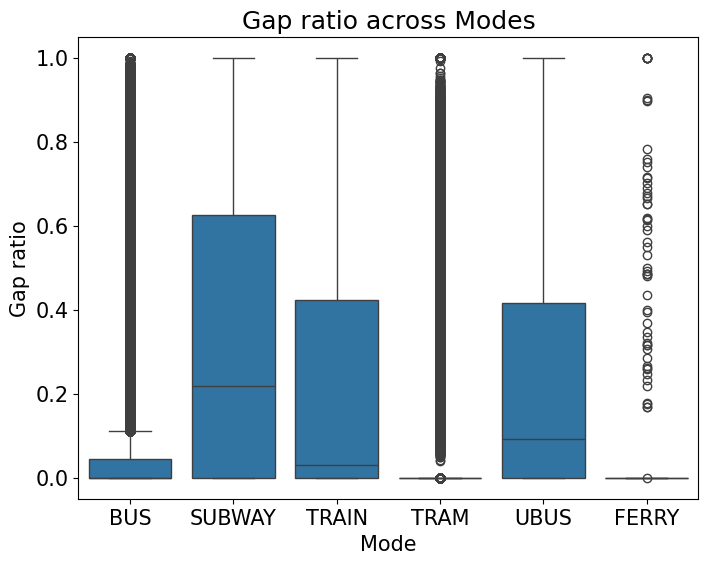

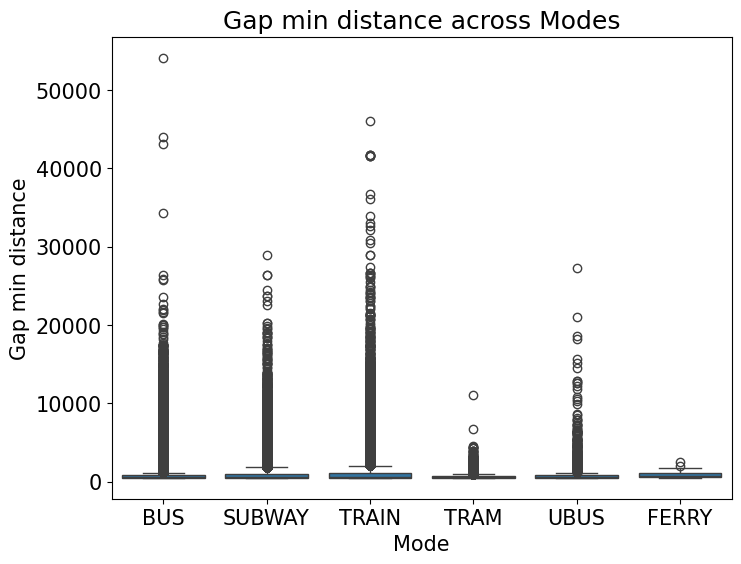

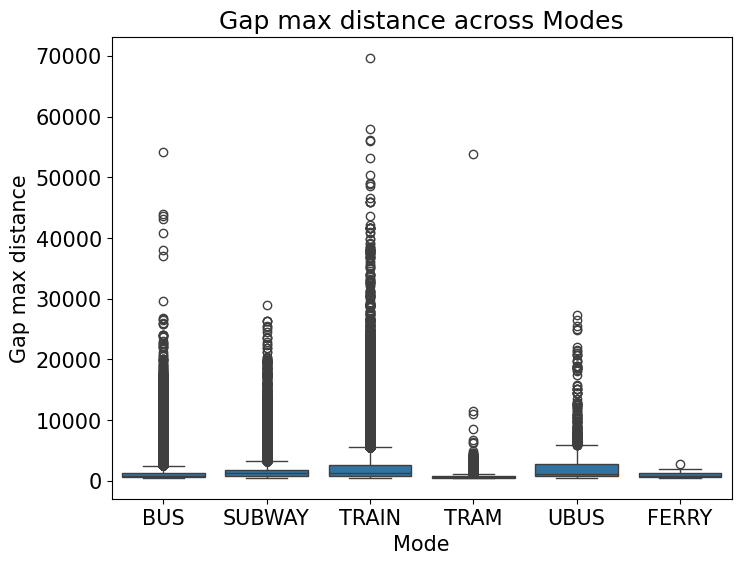

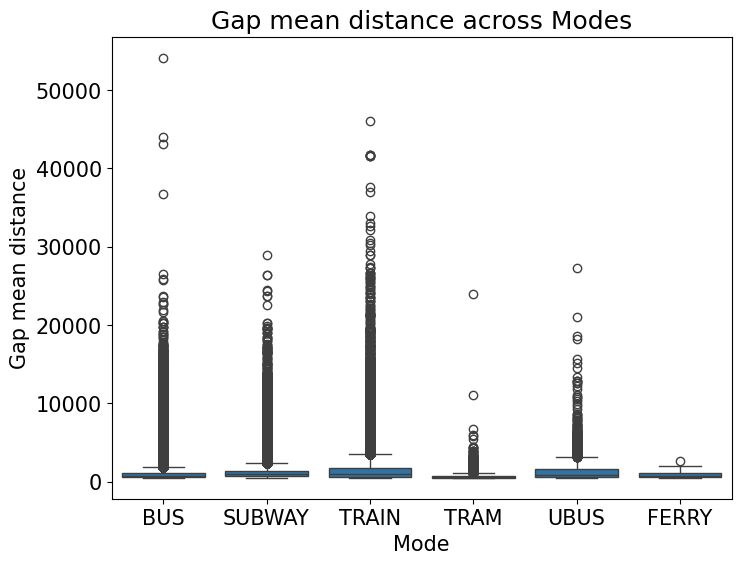

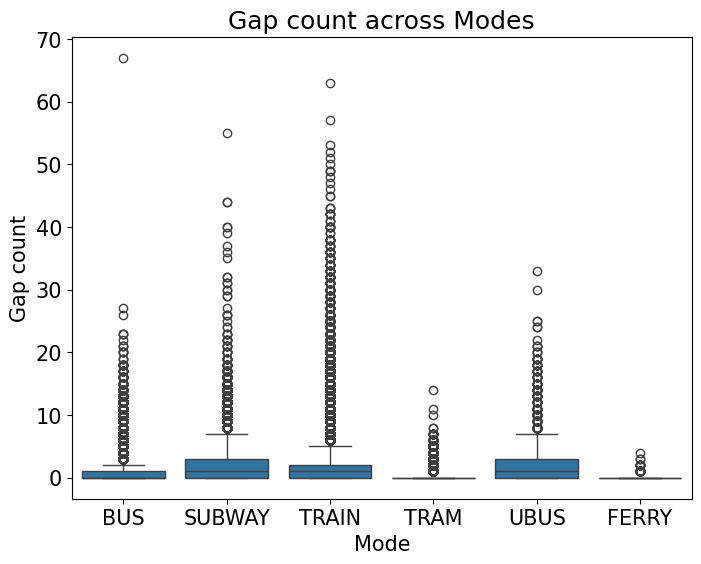

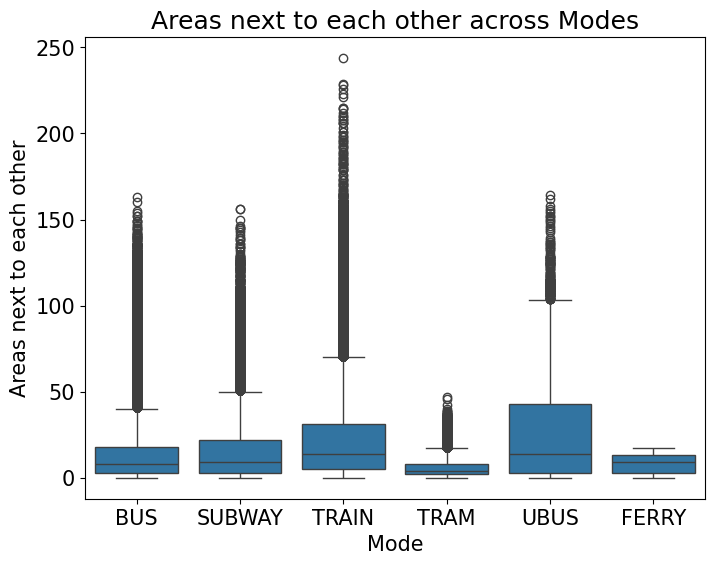

In [19]:
# compare the same feature acrossing different modes

def gap_comparison_across_modes(dataframes, column_name, modes):
    for column_name in columns:
        combined_df = pd.DataFrame()

        for df, mode in zip(dataframes, modes):
            if column_name in df.columns:  # cceck if the column exists in the current DataFrame
                temp_df = df[[column_name]].copy()  
                temp_df['Mode'] = mode 
                combined_df = pd.concat([combined_df, temp_df], ignore_index=True)

        if not combined_df.empty:
            plt.figure(figsize=(8, 6))
            plt.rcParams.update({'font.size': 15})
            sns.boxplot(x='Mode', y=column_name, data=combined_df)
            plt.title(f"{column_name} across Modes")
            plt.xlabel("Mode")
            plt.ylabel(column_name)
            plt.show()

dataframes = [P4_bus, P4_subway, P4_train, P4_tram, P4_ubus, P4_ferry]  
modes = ['BUS', 'SUBWAY', 'TRAIN', 'TRAM', 'UBUS', 'FERRY']
columns = ['Gap ratio', 'Gap min distance', 'Gap max distance', 'Gap mean distance', 'Gap count', 'Areas next to each other']
gap_comparison_across_modes(dataframes, columns, modes)

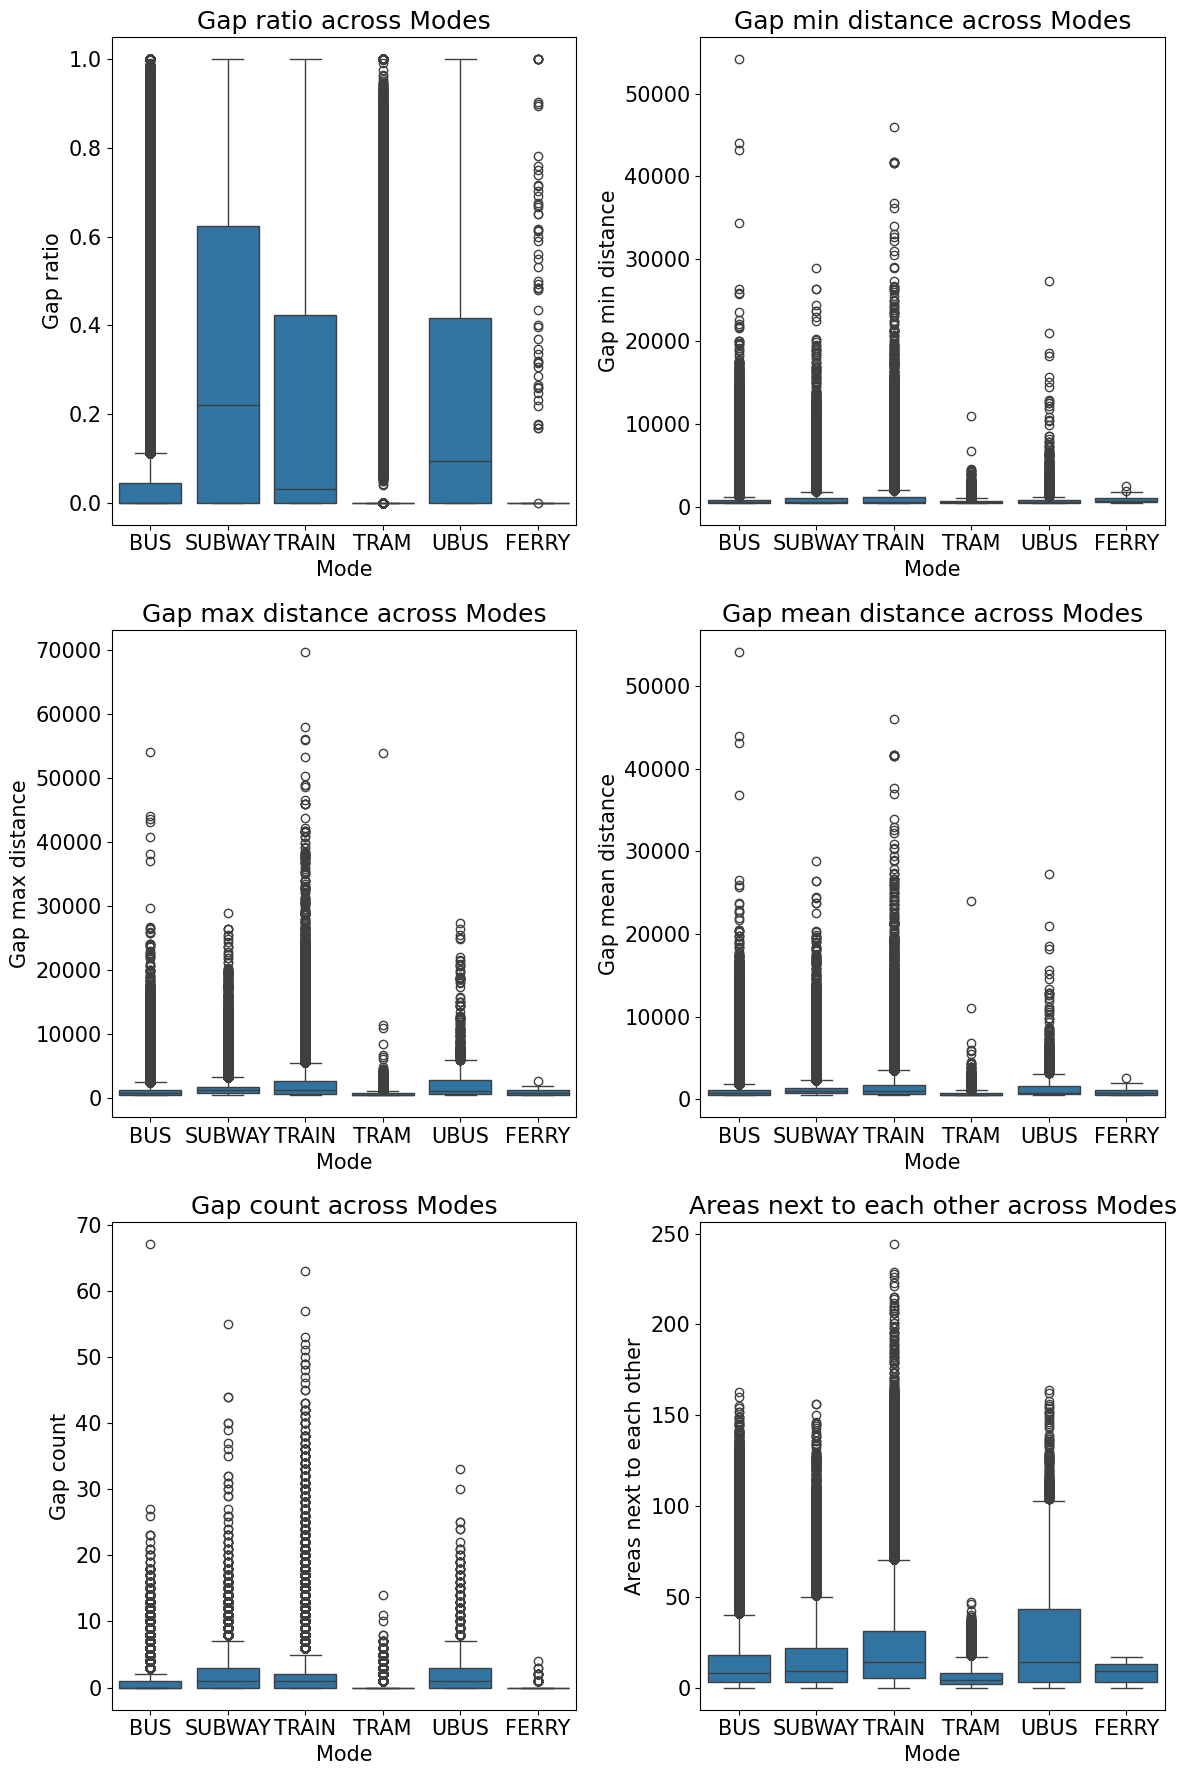

In [11]:
def gap_comparison_across_modes(dataframes, column_names, modes):
    # Calculate the number of rows and columns for the subplot grid
    num_columns = 2
    num_rows = len(column_names) // num_columns + (1 if len(column_names) % num_columns != 0 else 0)
    
    # Create a figure with a grid of subplots
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(2 * num_columns * 3, num_rows * 6))
    
    # Flatten the axes array for easy iteration
    axes = axes.flatten()
    
    for i, column_name in enumerate(column_names):
        ax = axes[i]
        
        # Combine the data for each mode
        combined_df = pd.DataFrame()
        for df, mode in zip(dataframes, modes):
            if column_name in df.columns:  # Check if the column exists in the current DataFrame
                temp_df = df[[column_name]].copy()
                temp_df['Mode'] = mode
                combined_df = pd.concat([combined_df, temp_df], ignore_index=True)
        
        if not combined_df.empty:
            # Plot the boxplot on the current axis
            sns.boxplot(x='Mode', y=column_name, data=combined_df, ax=ax)
            plt.rcParams.update({'font.size': 15})
            ax.set_title(f"{column_name} across Modes")
            ax.set_xlabel("Mode")
            ax.set_ylabel(column_name)
    
    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


dataframes = [P4_bus, P4_subway, P4_train, P4_tram, P4_ubus, P4_ferry]  
modes = ['BUS', 'SUBWAY', 'TRAIN', 'TRAM', 'UBUS', 'FERRY']
columns = ['Gap ratio', 'Gap min distance', 'Gap max distance', 'Gap mean distance', 'Gap count', 'Areas next to each other']
gap_comparison_across_modes(dataframes, columns, modes)

### quartiles not clear on plots, so summarized to a df

In [22]:
def quartiles_across_modes(dataframes, columns, modes):
    quartile_data = []

    # Loop over each column
    for column_name in columns:

        for df, mode in zip(dataframes, modes):
            if column_name in df.columns:  
                quartiles = df[column_name].describe(percentiles=[0.25, 0.5, 0.75])
                
                # Append quartile statistics to the summary DataFrame
                quartile_data.append({
                    'Mode': mode,
                    'Column': column_name,
                    'Min': quartiles['min'],
                    '25%': quartiles['25%'],
                    'Median': quartiles['50%'],
                    '75%': quartiles['75%'],
                    'Max': quartiles['max']
                })

    quartile_summary = pd.DataFrame(quartile_data)
    quartile_summary = quartile_summary[['Mode', 'Column', 'Min', '25%', 'Median', '75%', 'Max']]
    return quartile_summary

dataframes = [P4_bus, P4_subway, P4_train, P4_tram, P4_ubus, P4_ferry]  
modes = ['BUS', 'SUBWAY', 'TRAIN', 'TRAM', 'UBUS', 'FERRY']
columns = ['Gap ratio', 'Gap min distance', 'Gap max distance', 'Gap mean distance', 'Gap count', 'Areas next to each other']
quartile_summary_df = quartiles_across_modes(dataframes, columns, modes)

In [24]:
quartile_summary_df.to_csv('/scratch/work/lyub2/Problem_output_September/P4/PT_quartiles_original.csv', index = False)

In [25]:
quartile_summary_df

,Mode,Column,Min,25%,Median,75%,Max
0,BUS,Gap ratio,-3.972957e-16,0.000000,0.000000,0.044615,1.000000
1,SUBWAY,Gap ratio,-3.199258e-16,0.000000,0.219537,0.624626,1.000000
2,TRAIN,Gap ratio,-3.830935e-16,0.000000,0.030245,0.423840,1.000000
3,TRAM,Gap ratio,-4.368146e-16,0.000000,0.000000,0.000000,1.000000
4,UBUS,Gap ratio,-2.902133e-16,0.000000,0.092923,0.415970,1.000000
5,FERRY,Gap ratio,0.000000e+00,0.000000,0.000000,0.000000,1.000000
6,BUS,Gap min distance,5.000000e+02,500.000000,559.016994,790.569415,54134.092770
7,SUBWAY,Gap min distance,5.000000e+02,500.000000,559.016994,1030.776406,28893.122019
8,TRAIN,Gap min distance,5.000000e+02,500.000000,559.016994,1118.033989,45991.847104
9,TRAM,Gap min distance,5.000000e+02,500.000000,559.016994,707.106781,11025.538536


In [26]:
quartile_summary_df = quartile_summary_df.round(3)
quartile_summary_df

,Mode,Column,Min,25%,Median,75%,Max
0,BUS,Gap ratio,-0.0,0.000,0.000,0.045,1.000
1,SUBWAY,Gap ratio,-0.0,0.000,0.220,0.625,1.000
2,TRAIN,Gap ratio,-0.0,0.000,0.030,0.424,1.000
3,TRAM,Gap ratio,-0.0,0.000,0.000,0.000,1.000
4,UBUS,Gap ratio,-0.0,0.000,0.093,0.416,1.000
5,FERRY,Gap ratio,0.0,0.000,0.000,0.000,1.000
6,BUS,Gap min distance,500.0,500.000,559.017,790.569,54134.093
7,SUBWAY,Gap min distance,500.0,500.000,559.017,1030.776,28893.122
8,TRAIN,Gap min distance,500.0,500.000,559.017,1118.034,45991.847
9,TRAM,Gap min distance,500.0,500.000,559.017,707.107,11025.539


In [27]:
quartile_summary_df.to_csv('/scratch/work/lyub2/Problem_output_September/P4/PT_quartiles_round3.csv', index = False)

In [3]:
quartile_summary_df = pd.read_csv('/scratch/work/lyub2/Problem_output_September/P4/PT_quartiles_round3.csv')

In [11]:
bus_summary = quartile_summary_df[quartile_summary_df['Mode'] == 'BUS'].reset_index(drop = True)
bus_summary['Acceptable value'] = bus_summary['75%']+ 1.5 * (bus_summary['75%'] - bus_summary['25%'])
bus_summary

,Mode,Column,Min,25%,Median,75%,Max,Acceptable value
0,BUS,Gap ratio,-0.0,0.000,0.000,0.045,1.000,0.1125
1,BUS,Gap min distance,500.0,500.000,559.017,790.569,54134.093,1226.4225
2,BUS,Gap max distance,500.0,559.017,790.569,1346.291,54134.093,2527.2020
3,BUS,Gap mean distance,500.0,559.017,707.107,1082.559,54134.093,1867.8720
4,BUS,Gap count,0.0,0.000,0.000,1.000,67.000,2.5000
5,BUS,Areas next to each other,0.0,3.000,8.000,18.000,163.000,40.5000


In [12]:
train_summary = quartile_summary_df[quartile_summary_df['Mode'] == 'TRAIN'].reset_index(drop = True)
train_summary['Acceptable value'] = train_summary['75%']+ 1.5 * (train_summary['75%'] - train_summary['25%'])
train_summary

,Mode,Column,Min,25%,Median,75%,Max,Acceptable value
0,TRAIN,Gap ratio,-0.0,0.000,0.030,0.424,1.000,1.0600
1,TRAIN,Gap min distance,500.0,500.000,559.017,1118.034,45991.847,2045.0850
2,TRAIN,Gap max distance,500.0,707.107,1346.291,2657.536,69682.315,5583.1795
3,TRAIN,Gap mean distance,500.0,623.142,1030.776,1767.767,45991.847,3484.7045
4,TRAIN,Gap count,0.0,0.000,1.000,2.000,63.000,5.0000
5,TRAIN,Areas next to each other,0.0,5.000,14.000,31.000,244.000,70.0000


In [13]:
subway_summary = quartile_summary_df[quartile_summary_df['Mode'] == 'SUBWAY'].reset_index(drop = True)
subway_summary['Acceptable value'] = subway_summary['75%']+ 1.5 * (subway_summary['75%'] - subway_summary['25%'])
subway_summary

,Mode,Column,Min,25%,Median,75%,Max,Acceptable value
0,SUBWAY,Gap ratio,-0.0,0.000,0.220,0.625,1.000,1.5625
1,SUBWAY,Gap min distance,500.0,500.000,559.017,1030.776,28893.122,1826.9400
2,SUBWAY,Gap max distance,500.0,790.569,1274.755,1802.776,28893.122,3321.0865
3,SUBWAY,Gap mean distance,500.0,707.107,954.302,1366.927,28893.122,2356.6570
4,SUBWAY,Gap count,0.0,0.000,1.000,3.000,55.000,7.5000
5,SUBWAY,Areas next to each other,0.0,3.000,9.000,22.000,156.000,50.5000


### Non-PT

In [3]:
P4_beacon = pd.read_csv('/scratch/work/lyub2/Problem_output_September/P4/P4_beacon.csv')
P4_bike = pd.read_csv('/scratch/work/lyub2/Problem_output_September/P4/P4_bike.csv')
P4_car = pd.read_csv('/scratch/work/lyub2/Problem_output_September/P4/P4_car.csv')
P4_run = pd.read_csv('/scratch/work/lyub2/Problem_output_September/P4/P4_run.csv')
P4_unknown = pd.read_csv('/scratch/work/lyub2/Problem_output_September/P4/P4_unknown.csv')
P4_walk = pd.read_csv('/scratch/work/lyub2/Problem_output_September/P4/P4_walk.csv')

In [28]:
P4_beacon

,Mode,Temp,Tripchain ID,Leg Order,Total distance,Adjacent distance,Gap ratio,Gap min distance,Gap max distance,Gap mean distance,Gap count,Areas next to each other
0,BEACON,fGrP1kYqgYwx,0.0,1.0,853.553391,853.553391,0.0,NaN,NaN,NaN,0,4


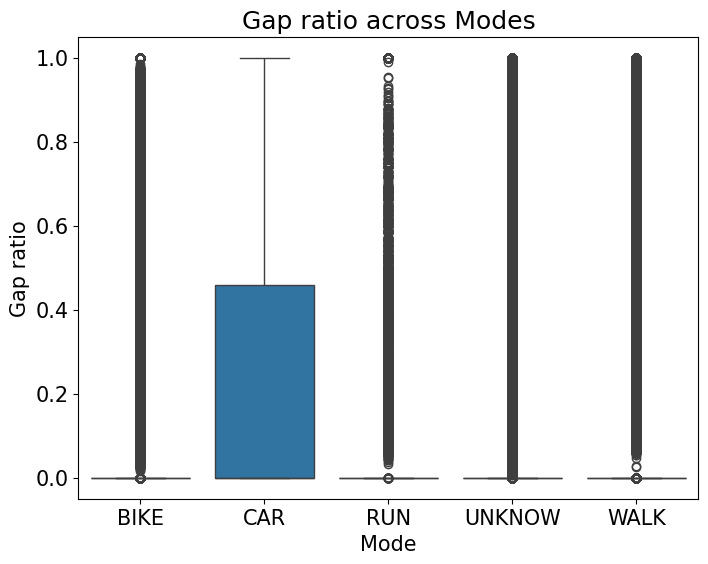

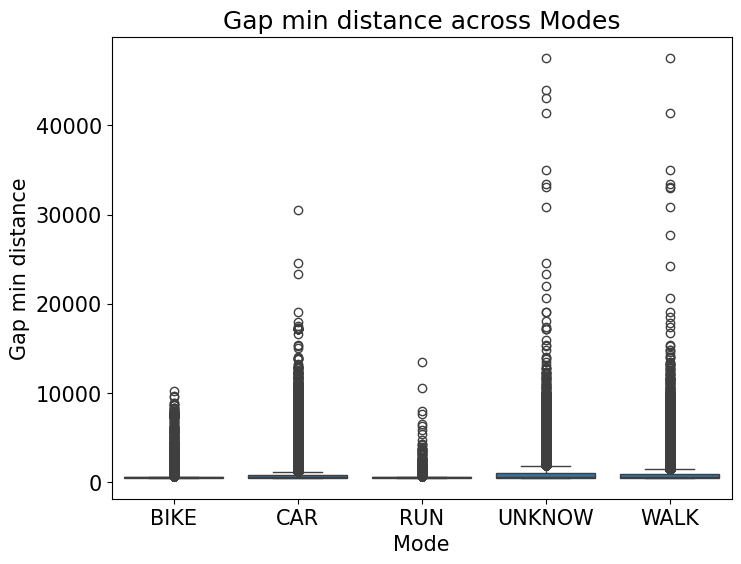

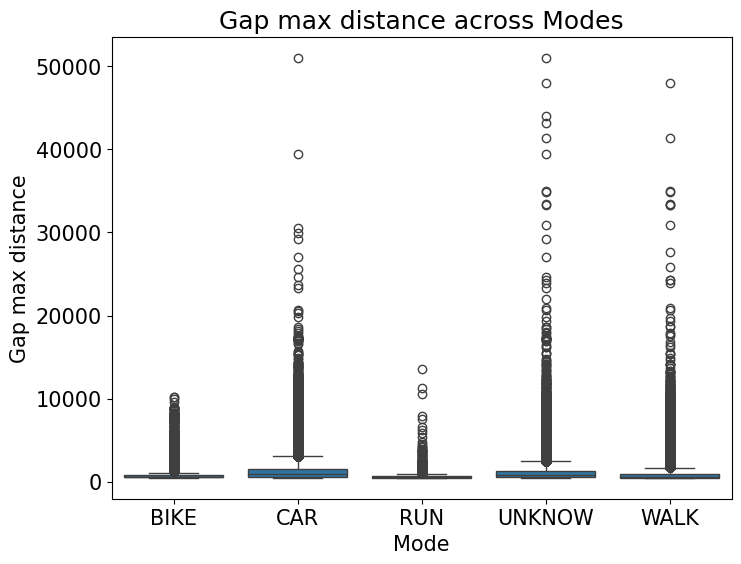

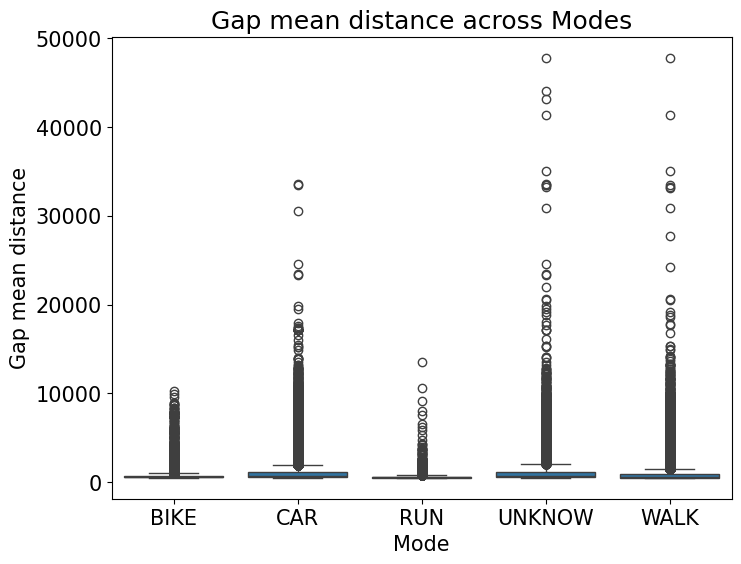

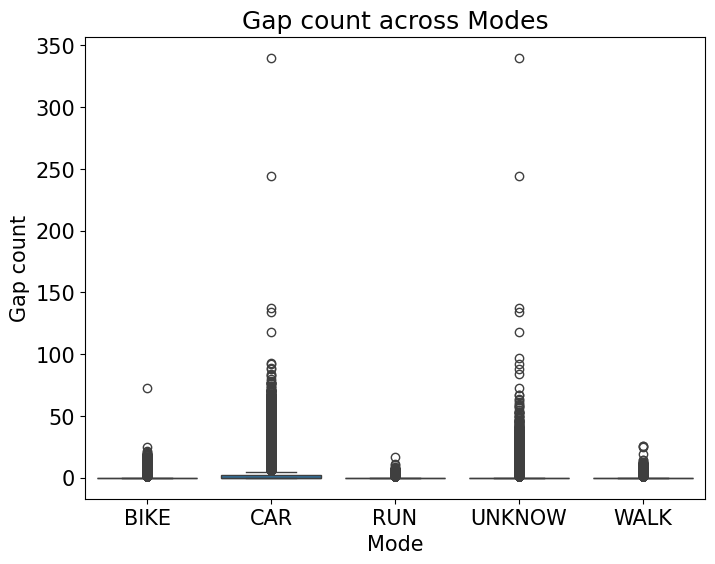

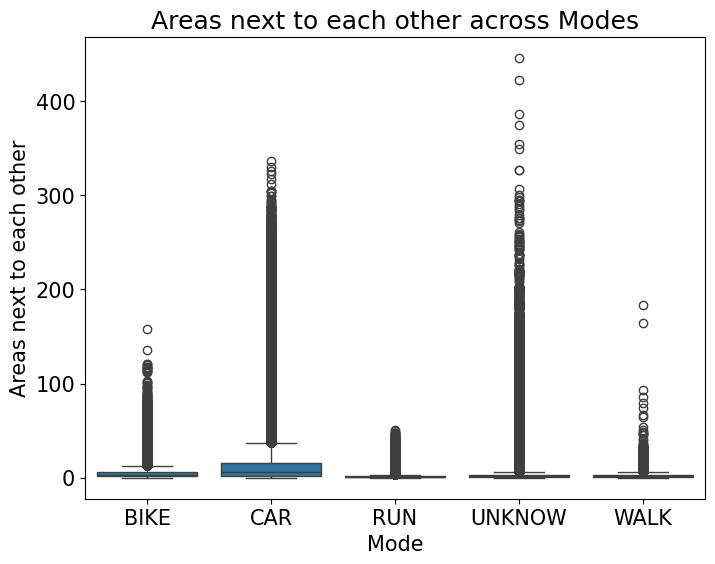

In [29]:
def gap_comparison_across_modes(dataframes, column_name, modes):
    for column_name in columns:
        combined_df = pd.DataFrame()

        for df, mode in zip(dataframes, modes):
            if column_name in df.columns:  # cceck if the column exists in the current DataFrame
                temp_df = df[[column_name]].copy()  
                temp_df['Mode'] = mode 
                combined_df = pd.concat([combined_df, temp_df], ignore_index=True)

        if not combined_df.empty:
            plt.figure(figsize=(8, 6))
            plt.rcParams.update({'font.size': 15})
            sns.boxplot(x='Mode', y=column_name, data=combined_df)
            plt.title(f"{column_name} across Modes")
            plt.xlabel("Mode")
            plt.ylabel(column_name)
            plt.show()

dataframes = [P4_bike, P4_car, P4_run, P4_unknown, P4_walk]  
modes = ['BIKE', 'CAR', 'RUN', 'UNKNOW', 'WALK']
columns = ['Gap ratio', 'Gap min distance', 'Gap max distance', 'Gap mean distance', 'Gap count', 'Areas next to each other']
gap_comparison_across_modes(dataframes, columns, modes)

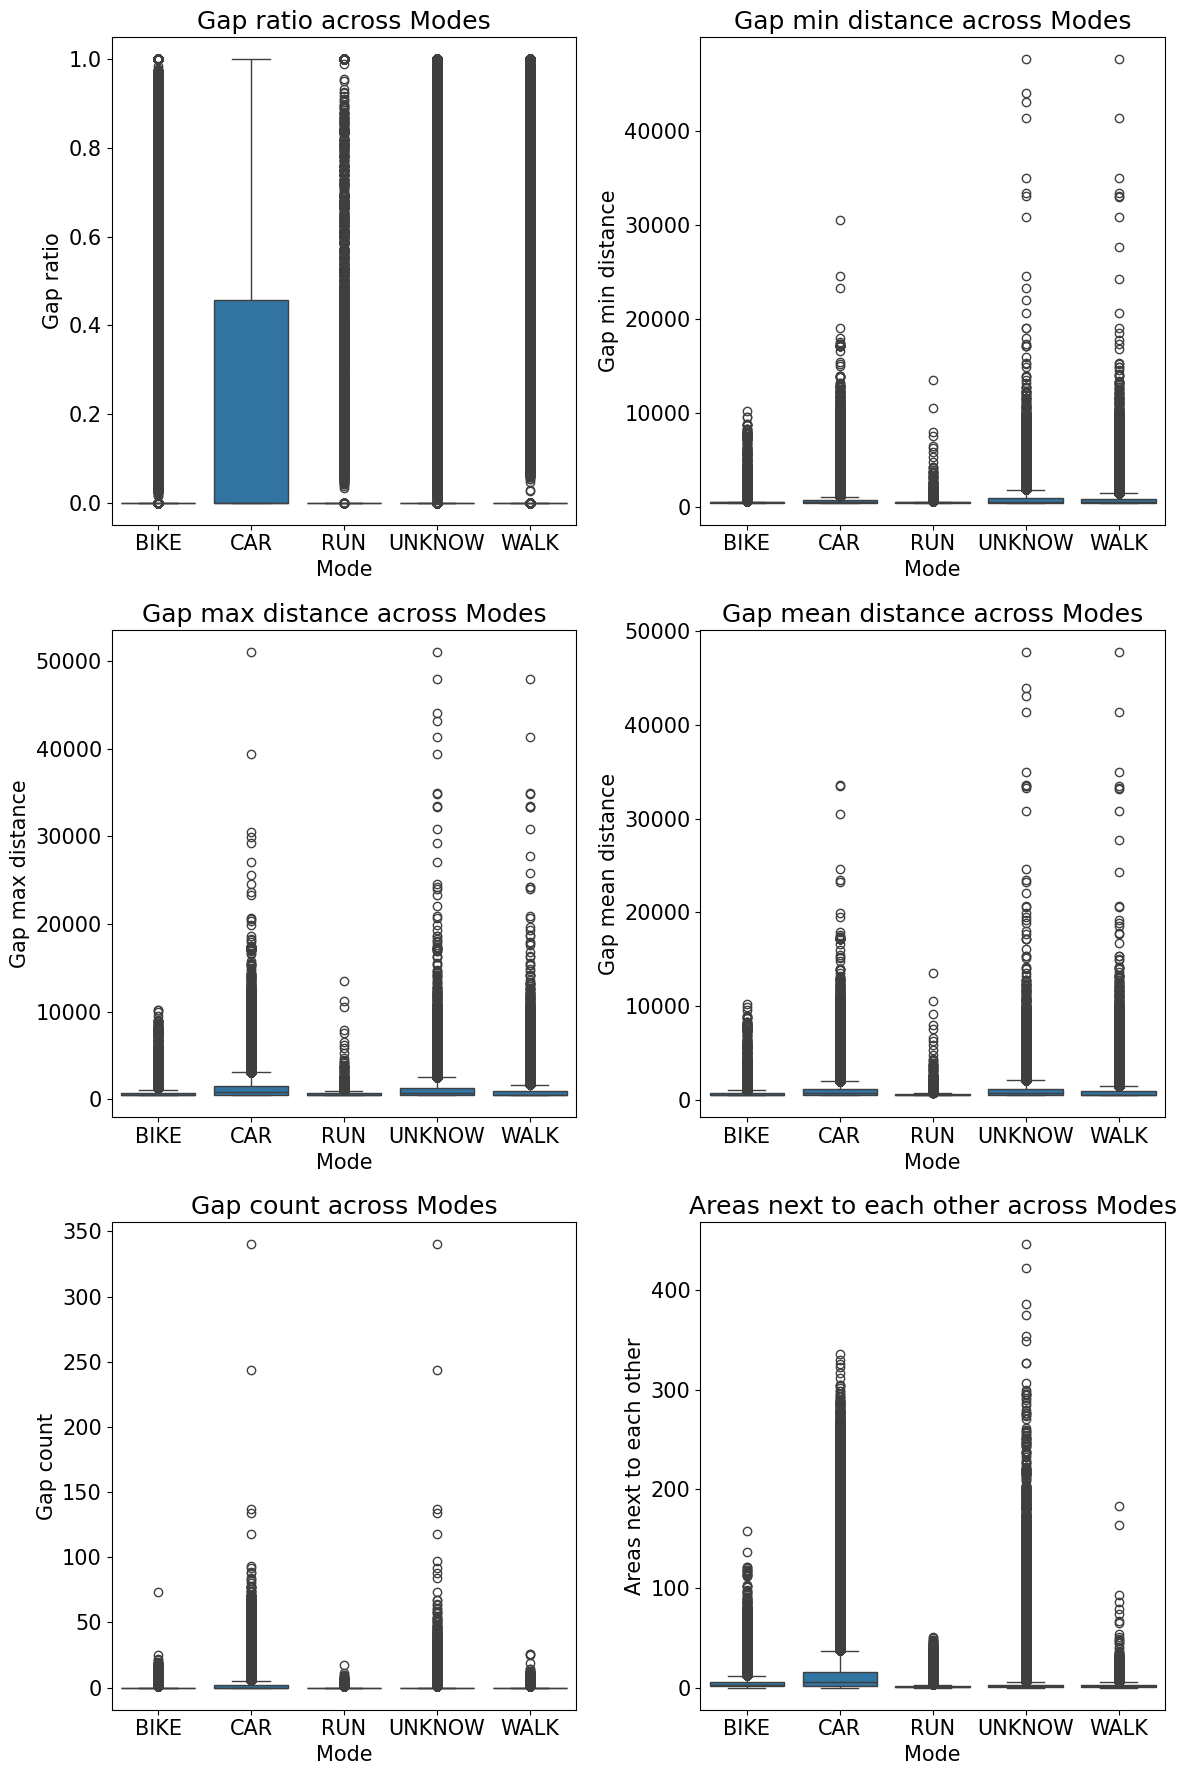

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def gap_comparison_across_modes(dataframes, column_names, modes):
    # Calculate the number of rows and columns for the subplot grid
    num_columns = 2
    num_rows = len(column_names) // num_columns + (1 if len(column_names) % num_columns != 0 else 0)
    
    # Create a figure with a grid of subplots
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(2 * num_columns * 3, num_rows * 6))
    
    # Flatten the axes array for easy iteration
    axes = axes.flatten()
    
    for i, column_name in enumerate(column_names):
        ax = axes[i]
        
        # Combine the data for each mode
        combined_df = pd.DataFrame()
        for df, mode in zip(dataframes, modes):
            if column_name in df.columns:  # Check if the column exists in the current DataFrame
                temp_df = df[[column_name]].copy()
                temp_df['Mode'] = mode
                combined_df = pd.concat([combined_df, temp_df], ignore_index=True)
        
        if not combined_df.empty:
            # Plot the boxplot on the current axis
            sns.boxplot(x='Mode', y=column_name, data=combined_df, ax=ax)
            plt.rcParams.update({'font.size': 15})
            ax.set_title(f"{column_name} across Modes")
            ax.set_xlabel("Mode")
            ax.set_ylabel(column_name)
    
    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Your dataframes and modes
dataframes = [P4_bike, P4_car, P4_run, P4_unknown, P4_walk]  
modes = ['BIKE', 'CAR', 'RUN', 'UNKNOW', 'WALK']
columns = ['Gap ratio', 'Gap min distance', 'Gap max distance', 'Gap mean distance', 'Gap count', 'Areas next to each other']
gap_comparison_across_modes(dataframes, columns, modes)

In [13]:
def quartiles_across_modes(dataframes, columns, modes):
    quartile_data = []

    # Loop over each column
    for column_name in columns:

        for df, mode in zip(dataframes, modes):
            if column_name in df.columns:  
                quartiles = df[column_name].describe(percentiles=[0.25, 0.5, 0.75])
                
                # Append quartile statistics to the summary DataFrame
                quartile_data.append({
                    'Mode': mode,
                    'Column': column_name,
                    'Min': quartiles['min'],
                    '25%': quartiles['25%'],
                    'Median': quartiles['50%'],
                    '75%': quartiles['75%'],
                    'Max': quartiles['max']
                })

    quartile_summary = pd.DataFrame(quartile_data)
    quartile_summary = quartile_summary[['Mode', 'Column', 'Min', '25%', 'Median', '75%', 'Max']]
    return quartile_summary

dataframes = [P4_bike, P4_car, P4_run, P4_unknown, P4_walk]  
modes = ['BIKE', 'CAR', 'RUN', 'UNKNOWN', 'WALK']
columns = ['Gap ratio', 'Gap min distance', 'Gap max distance', 'Gap mean distance', 'Gap count', 'Areas next to each other']
quartile_summary_df = quartiles_across_modes(dataframes, columns, modes).round(3)

In [33]:
quartile_summary_df

,Mode,Column,Min,25%,Median,75%,Max
0,BIKE,Gap ratio,-0.0,0.000,0.000,0.000,1.000
1,CAR,Gap ratio,-0.0,0.000,0.000,0.458,1.000
2,RUN,Gap ratio,-0.0,0.000,0.000,0.000,1.000
3,UNKNOWN,Gap ratio,-0.0,0.000,0.000,0.000,1.000
4,WALK,Gap ratio,-0.0,0.000,0.000,0.000,1.000
5,BIKE,Gap min distance,500.0,500.000,559.017,559.017,10253.048
6,CAR,Gap min distance,500.0,500.000,559.017,790.569,30501.025
7,RUN,Gap min distance,500.0,500.000,559.017,559.017,13500.000
8,UNKNOWN,Gap min distance,500.0,500.000,559.017,1030.776,47594.643
9,WALK,Gap min distance,500.0,500.000,559.017,901.388,47594.643


In [15]:
quartile_summary_df.to_csv('/scratch/work/lyub2/Problem_output_September/P4/Non_PT_quartiles_original.csv', index = False)

## Quality categorization

In [8]:
conda install -c anaconda python-graphviz

Retrieving notices: ...working... done
Channels:
 - anaconda
 - defaults
 - conda-forge
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 24.3.0
    latest version: 24.11.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /scratch/work/lyub2/.conda_envs/lb-env

  added / updated specs:
    - python-graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    atk-1.0-2.36.0             |       ha1a6a79_0         537 KB  anaconda
    ca-certificates-2024.9.24  |       h06a4308_0         137 KB  anaconda
    certifi-2024.8.30          |  py312h06a4308_0         165 KB  anaconda
    fribidi-1.0.10             |       h7b6447c_0         115 KB  anaconda
    gdk-pixbuf-2.42.12         |       hb9ae30d_0         516 KB  conda-forge
    glib-2.80.3     

In [9]:
conda install -c anaconda pydot

Channels:
 - anaconda
 - defaults
 - conda-forge
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 24.3.0
    latest version: 24.11.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /scratch/work/lyub2/.conda_envs/lb-env

  added / updated specs:
    - pydot


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pydot-1.4.2                |  py312h06a4308_0          53 KB  anaconda
    pyparsing-2.4.7            |     pyhd3eb1b0_0          59 KB  anaconda
    ------------------------------------------------------------
                                           Total:         112 KB

The following NEW packages will be INSTALLED:

  pydot              anaconda/linux-64::pydot-1.4.2-py312h06a4308_0 

The following packages will be SUPERSEDED by a hi

In [4]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [15]:
a = 1 - (0.66 * 0.135 + 0.34 * 0.0806)
a

0.883496

In [23]:
# decision tree

from graphviz import Digraph

# Create a new directed graph
dot = Digraph(format="png", engine="dot")

dot.node("Dataset", "Trip Chain Dataset", shape = 'box')

# PT and Non_PT 
dot.node("PT", "PT Data \n(34%)", shape = 'box')
dot.node("Non_PT", "Non-PT Data \n(66%)", shape = 'box')
dot.edge("Dataset", "PT")
dot.edge("Dataset", "Non_PT")

# Problem 2 for PT
dot.node("PT_Problem2_Yes", "Problem 2: Yes \n34% * 8.06% = 2.74%")
dot.node("PT_Problem2_No", "Problem 2: No \n31.26%")
dot.edge("PT", "PT_Problem2_Yes")
dot.edge("PT", "PT_Problem2_No")

# Problem 1 for Non_PT
dot.node("Non_PT_Problem1_No", "Problem 1: No \n57.09%")
dot.node("Non_PT_Problem1_Yes", "Problem 1: Yes \n66% * 13.50% = 8.91%")
dot.edge("Non_PT", "Non_PT_Problem1_No")
dot.edge("Non_PT", "Non_PT_Problem1_Yes")


# Problem 3 for combined
dot.node("Combined_Data", "Trip Chain Data After P1, P2\n(88.35%)", shape = 'box') #zz
dot.edge("PT_Problem2_No", "Combined_Data") #zz
dot.edge("Non_PT_Problem1_No", "Combined_Data") #zz

dot.node("Problem3_Yes", "Problem 3: Yes \n88.35% * 20.79% = 18.37%")
dot.node("Problem3_No", "Problem 3: No \n69.98%")
dot.edge("Combined_Data", "Problem3_Yes")
dot.edge("Combined_Data", "Problem3_No")

# dot.node("Non_PT_Problem3_Yes", "Problem 3: Yes")
# dot.node("Non_PT_Problem3_No", "Problem 3: No")
# dot.edge("Non_PT_Problem1_No", "Non_PT_Problem3_Yes")
# dot.edge("Non_PT_Problem1_No", "Non_PT_Problem3_No")

# Problem 4 for both branches after passing Problem 3
dot.node("Problem4_Yes", "Problem 4: Yes \n69.98% * 25% = 17.49%")
dot.node("Problem4_No", "Problem 4: No \n52.49%")
dot.edge("Problem3_No", "Problem4_Yes")
dot.edge("Problem3_No", "Problem4_No")



# Save and render the graph
output_path = "/scratch/work/lyub2/Problem_output_September/P4/new_Data_Quality_Decision_Tree"
dot.render(output_path)


'/scratch/work/lyub2/Problem_output_September/P4/new_Data_Quality_Decision_Tree.png'

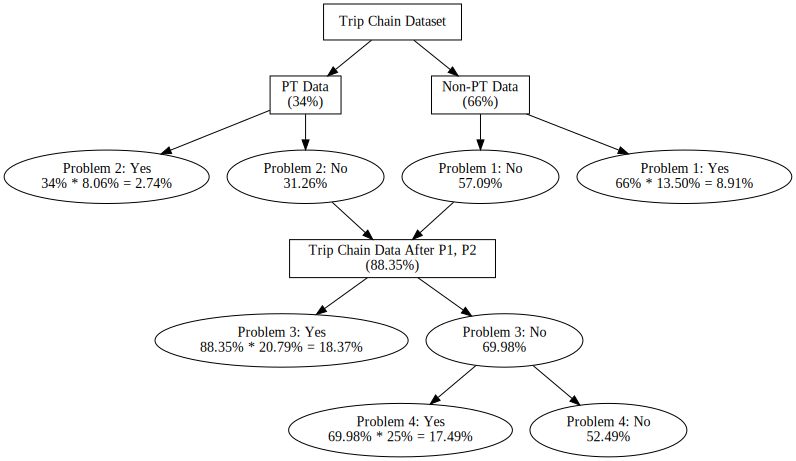

In [24]:
dot

In [12]:
# Create a new directed graph
dot = Digraph(format="png", engine="dot")

dot.node("Categorization", "Data has problem or not", shape = 'box')
 
dot.node("0", "Number of problems = 0")
dot.node(">=1", "Number of problems >= 1")

dot.node("Good_quality", "Good Quality Data", shape = 'plaintext', fontcolor = 'olivedrab4', fontname="Helvetica-Bold")
#dot.node("Mediocre_quality", "Mediocre Quality Data", shape = 'plaintext', fontcolor = 'orchid4', fontname="Helvetica-Bold")
dot.node("Bad_quality", "Bad Quality Data", shape = 'plaintext', fontcolor = 'lightpink3', fontname="Helvetica-Bold")
dot.edge("Categorization", "0")
#dot.edge("Categorization", "1_or_2")
dot.edge("Categorization", ">=1")

dot.edge("0", "Good_quality")
#dot.edge("1_or_2", "Mediocre_quality")
dot.edge(">=1", "Bad_quality")

dot.node("Good", "52.49%", shape = 'plaintext')
dot.node("Bad", "47.51%", shape = 'plaintext')

dot.edge("Good_quality", "Good")
# dot.edge("Mediocre_quality", "Med_PT")
# dot.edge("Mediocre_quality", "Med_nonPT")
dot.edge("Bad_quality", "Bad")

output_path = "/scratch/work/lyub2/Problem_output_September/P4/categorization"
dot.render(output_path)

'/scratch/work/lyub2/Problem_output_September/P4/categorization.png'

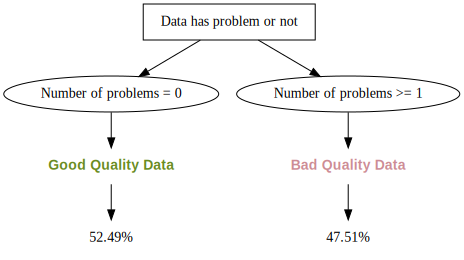

In [13]:
dot

## quality level proportion

In [2]:
from itertools import combinations

# Problem percentages
problem_probs = {
    "Problem 1": 0.135,
    "Problem 2": 0.0806,
    "Problem 3": 0.2079,
    "Problem 4": 0.25,
}

# Complementary probabilities (no issue for each problem)
complement_probs = {k: 1 - v for k, v in problem_probs.items()}

# Calculate probabilities for different numbers of issues (0, 1, 2, 3, 4)
# Total number of problems
num_problems = len(problem_probs)
problem_keys = list(problem_probs.keys())

# Helper function to calculate probability of a specific combination of problems
def calculate_combination_prob(comb, probs, complements):
    prob = 1
    for prob_key in probs.keys():
        if prob_key in comb:
            prob *= probs[prob_key]  # Probability of the problem occurring
        else:
            prob *= complements[prob_key]  # Probability of the problem NOT occurring
    return prob

# Probabilities for each data quality level
data_quality_probs = {"Good Quality": 0, "Mediocre Quality": 0, "Bad Quality": 0}

# Good quality: 0 problems
data_quality_probs["Good Quality"] = calculate_combination_prob([], problem_probs, complement_probs)



In [3]:
data_quality_probs

{'Good Quality': 0.47245656007500003, 'Mediocre Quality': 0, 'Bad Quality': 0}

In [4]:
data_quality_probs = {"Good Quality": 0, "Mediocre Quality": 0, "Bad Quality": 0}

# Good quality: 0 problems (no issues)
data_quality_probs["Good Quality"] = calculate_combination_prob([], problem_probs, complement_probs)

# Mediocre quality: 1 or 2 problems
for r in [1, 2]:
    for comb in combinations(problem_keys, r):
        data_quality_probs["Mediocre Quality"] += calculate_combination_prob(comb, problem_probs, complement_probs)

# Bad quality: 3 or 4 problems
for r in [3, 4]:
    for comb in combinations(problem_keys, r):
        data_quality_probs["Bad Quality"] += calculate_combination_prob(comb, problem_probs, complement_probs)

# Normalize to ensure proportions sum to 1
total_prob = sum(data_quality_probs.values())
data_quality_props = {k: v / total_prob for k, v in data_quality_probs.items()}

data_quality_props

{'Good Quality': 0.47245656007500003,
 'Mediocre Quality': 0.51305183995,
 'Bad Quality': 0.014491599975000002}

In [2]:
# p1 non-PT
p1 = 0.135* 0.66
p1_r = 0.66-p1
print(p1, p1_r)

0.08910000000000001 0.5709


In [6]:
#p2 PT
p2 = 0.0806*0.34
p2_r = 0.34 - p2
print(p2, p2_r)

0.027404000000000005 0.31259600000000004


In [4]:
before_p3 = 1-p1-p2
p3 = before_p3 * 0.2079
p3_r = before_p3 - p3
print(before_p3, p3, p3_r)


0.8834960000000001 0.18367881840000003 0.6998171816000001


In [7]:
p4 = p3_r * 0.25
p4_r = p3_r - p4
print(p4, p4_r)

0.17495429540000002 0.5248628862


In [14]:
0.8835*(1-0.2079)/4

0.1749550875

In [15]:
0.8835*(1-0.2079)*3/4

0.5248652625

In [13]:
good = round(p4_r,4) * 100
bad_pt = p2 + (p2_r*0.2079) + (p2_r - p2_r*0.2079)*0.25
bad_non = p1 + (p1_r*0.2079) + (p1_r - p1_r*0.2079)*0.25
bad = round(bad_pt + bad_non, 4) * 100
med = 1 - good - bad

print(good, bad, med)

52.480000000000004 47.510000000000005 -98.99000000000001
